Iteration 1/50, Best Q: 0.3539
Iteration 2/50, Best Q: 0.3539
Iteration 3/50, Best Q: 0.3539
Iteration 4/50, Best Q: 0.3539
Iteration 5/50, Best Q: 0.3539
Iteration 6/50, Best Q: 0.3539
Iteration 7/50, Best Q: 0.3539
Iteration 8/50, Best Q: 0.3912
Iteration 9/50, Best Q: 0.3912
Iteration 10/50, Best Q: 0.3912
Iteration 11/50, Best Q: 0.3912
Iteration 12/50, Best Q: 0.4822
Iteration 13/50, Best Q: 0.4822
Iteration 14/50, Best Q: 0.4822
Iteration 15/50, Best Q: 0.4822
Iteration 16/50, Best Q: 0.4822
Iteration 17/50, Best Q: 0.4822
Iteration 18/50, Best Q: 0.4822
Iteration 19/50, Best Q: 0.4822
Iteration 20/50, Best Q: 0.4822
Iteration 21/50, Best Q: 0.4822
Iteration 22/50, Best Q: 0.4822
Iteration 23/50, Best Q: 0.4822
Iteration 24/50, Best Q: 0.4822
Iteration 25/50, Best Q: 0.4822
Iteration 26/50, Best Q: 0.4822
Iteration 27/50, Best Q: 0.4822
Iteration 28/50, Best Q: 0.4822
Iteration 29/50, Best Q: 0.4822
Iteration 30/50, Best Q: 0.4822
Iteration 31/50, Best Q: 0.4822
Iteration 32/50, 

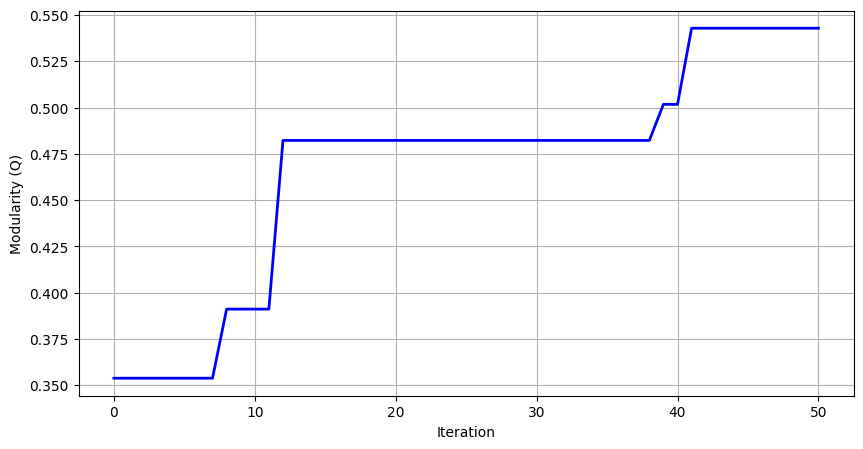

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import random
import warnings
warnings.filterwarnings('ignore')

class SSACD:
    def __init__(self, graph, num_salps=50, max_iter=100, 
                 levy_alpha1=1.5, levy_alpha2=1.1, c1=2.0):
        """
        Salp Swarm Algorithm for Community Detection with:
        - Two-Stage Levy Flight
        - Opposition-Based Learning
        """
        self.graph = graph
        self.num_nodes = graph.number_of_nodes()
        self.num_salps = num_salps
        self.max_iter = max_iter
        self.levy_alpha1 = levy_alpha1
        self.levy_alpha2 = levy_alpha2
        self.c1 = c1
        
        # Fix the number of communities to avoid shape mismatches
        self.num_comms = min(10, self.num_nodes)
        
        # Initialize population
        self.population = self.initialize_population()
        self.opposition_pop = self.generate_opposition(self.population)
        self.combined_pop = np.concatenate((self.population, self.opposition_pop))
        
        # Fitness evaluation
        self.fitness = np.zeros(2 * num_salps)
        self.best_solution = None
        self.best_fitness = -np.inf
        self.fitness_history = []
        
    def initialize_population(self):
        """Initialize salp positions with random community assignments"""
        population = []
        for _ in range(self.num_salps):
            comm_assignments = np.random.randint(0, self.num_comms, size=self.num_nodes)
            matrix = np.zeros((self.num_nodes, self.num_comms))
            for node, comm in enumerate(comm_assignments):
                matrix[node, comm] = 1
            population.append(matrix)
        return population
    
    def generate_opposition(self, population):
        """Generate opposition solutions using Opposition-Based Learning"""
        opposition = []
        for matrix in population:
            opp_matrix = np.zeros_like(matrix)
            for node in range(self.num_nodes):
                current_comm = np.argmax(matrix[node])
                opposite_comm = (current_comm + 1) % self.num_comms
                opp_matrix[node, opposite_comm] = 1
            opposition.append(opp_matrix)
        return opposition
    
    def modularity(self, partition_matrix):
        """Calculate modularity (Q) for a partition matrix"""
        m = self.graph.number_of_edges()
        if m == 0:
            return 0
        A = nx.adjacency_matrix(self.graph).todense()
        k = np.array([d for n, d in self.graph.degree()])
        B = A - np.outer(k, k) / (2 * m)
        communities = np.argmax(partition_matrix, axis=1)
        Q = sum(B[i, j] for i in range(self.num_nodes) for j in range(self.num_nodes) if communities[i] == communities[j])
        return Q / (2 * m)
    
    def evaluate_fitness(self):
        """Evaluate fitness of all solutions"""
        for i, matrix in enumerate(self.combined_pop):
            self.fitness[i] = self.modularity(matrix)
            if self.fitness[i] > self.best_fitness:
                self.best_fitness = self.fitness[i]
                self.best_solution = matrix.copy()
        sorted_indices = np.argsort(self.fitness)[::-1]
        self.population = [self.combined_pop[i] for i in sorted_indices[:self.num_salps]]
        self.fitness_history.append(self.best_fitness)
    
    def levy_flight(self, alpha):
        """Generate step from Levy distribution"""
        beta = 1.0
        sigma_u = (math.gamma(1 + alpha) * math.sin(math.pi * alpha / 2) / 
                  (math.gamma((1 + alpha) / 2) * alpha * 2 ** ((alpha - 1) / 2))) ** (1 / alpha)
        sigma_v = 1
        u = np.random.normal(0, sigma_u)
        v = np.random.normal(0, sigma_v)
        return (u / (abs(v) ** (1 / alpha))) * beta
    
    def update_positions(self, iteration):
        """Update salp positions using two-stage Levy flight"""
        c1 = self.c1 * math.exp(-(4 * iteration / self.max_iter) ** 2)
        alpha = self.levy_alpha1 if iteration < 0.5 * self.max_iter else self.levy_alpha2
        new_population = []
        for i in range(self.num_salps):
            step = self.levy_flight(alpha)
            if i == 0:
                leader_matrix = self.best_solution.copy()
                for node in range(self.num_nodes):
                    if random.random() < 0.1:
                        current_comm = np.argmax(leader_matrix[node])
                        new_comm = (current_comm + int(step)) % self.num_comms
                        leader_matrix[node] = 0
                        leader_matrix[node, new_comm] = 1
                new_population.append(leader_matrix)
            else:
                prev_matrix = self.population[i-1].copy()
                curr_matrix = self.population[i].copy()
                new_matrix = np.where(random.random() < abs(step), prev_matrix, curr_matrix)
                for node in range(self.num_nodes):
                    if np.sum(new_matrix[node]) != 1:
                        comm = np.argmax(new_matrix[node])
                        new_matrix[node] = 0
                        new_matrix[node, comm] = 1
                new_population.append(new_matrix)
        self.population = new_population
    
    def run(self):
        """Execute the optimization process"""
        self.evaluate_fitness()
        for iter in range(self.max_iter):
            self.update_positions(iter)
            self.opposition_pop = self.generate_opposition(self.population)
            self.combined_pop = np.concatenate((self.population, self.opposition_pop))
            self.evaluate_fitness()
            print(f"Iteration {iter+1}/{self.max_iter}, Best Q: {self.best_fitness:.4f}")
        return self.best_solution, self.best_fitness
    
    def get_communities(self, solution_matrix):
        return np.argmax(solution_matrix, axis=1)
    
    def plot_fitness(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.fitness_history, 'b-', linewidth=2)
        plt.xlabel('Iteration')
        plt.ylabel('Modularity (Q)')
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    G = nx.karate_club_graph()
    ssacd = SSACD(G, num_salps=30, max_iter=50)
    best_solution, best_fitness = ssacd.run()
    communities = ssacd.get_communities(best_solution)
    print("Detected communities:", communities)
    print("Modularity:", best_fitness)
    ssacd.plot_fitness()
